In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

In [2]:

c2 = 0.2

alpha = 1

def loss_function(a, y):
    return c2*(a-y)**2 -alpha



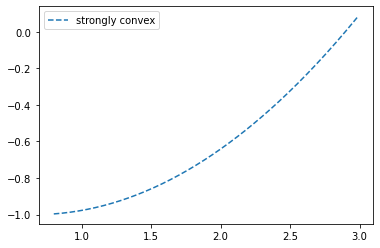

In [3]:
# evenly sampled time at 200ms intervals
thetas = np.arange(0.8, 3., 0.01)
y = np.random.normal(loc=1, scale=0.3)

# red dashes, blue squares and green triangles
plt.plot(thetas, loss_function(thetas, y), '--', label='strongly convex')
plt.legend()
plt.show()

In [11]:
def evaluate_theta(theta, random_seed):
    rng = np.random.RandomState(random_seed)
    size=10000
    actions = rng.normal(loc=theta, scale=0.3, size=size)
    y = rng.normal(loc=1, scale=0.3, size=size)
    loss = np.mean(c2*(actions-y)**2 -alpha)
    return loss
    

In [12]:
import jax
import jax.numpy as jnp
import jaxopt

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

def conservative_loss(param, data):
    logging_samples, logging_losses, logging_propensities = data
    n = logging_losses.shape[0]
    lambd = np.sqrt(18*(np.log(n)))
#     lambd = 0.01
    importance_weights = pdf(param, logging_samples)/logging_propensities
    mean = jnp.mean(logging_losses * importance_weights)
    std = jnp.std(logging_losses * importance_weights)
    return mean + lambd / np.sqrt(n) * std 



In [13]:
loss_mode = 'convex'
loss_function = loss_function

In [14]:
def optimize(loss_fun, init_parameter, args):
    lower_bounds = -3*jnp.ones_like(init_parameter)
    upper_bounds = 3*jnp.ones_like(init_parameter)
    bounds = (lower_bounds, upper_bounds)

#     lbfgsb = jaxopt.ScipyMinimize(fun=loss_fun, method="L-BFGS-B").run(init_parameter, bounds=bounds, data=args)
    lbfgsb = jaxopt.ScipyBoundedMinimize(fun=loss_fun, method="l-bfgs-b").run(init_parameter, bounds=bounds, data=args)

    lbfgs_sol = lbfgsb.params
        
    return lbfgs_sol

# Experiment

In [16]:
logging_mu = 2.5
logging_scale = 0.3

def get_logging_data(n_samples, logging_mu, logging_scale, random_seed=123):

    rng = np.random.RandomState(random_seed)
    y_0 = rng.normal(loc=1, scale=logging_scale)
    action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
    losses = loss_function(action_samples, y_0)
    logging_pdf = norm(loc=logging_mu, scale=logging_scale).pdf
    propensities = logging_pdf(action_samples)
    loss = np.mean(losses)

    logging_data = action_samples, losses, propensities

    return logging_data

settings = {
    'M':15,
    'n_0':100
}

### Repeated CRM

In [41]:

def repeated_crm_experiment(logging_mu, logging_scale, settings, random_seed=123):

    loss_fun = conservative_loss 
    print('-' * 80)
    print('CRM experiment, \mu_0={}, \sigma={}, seed {}'.format(logging_mu, logging_scale, random_seed))
    
    rng = np.random.RandomState(random_seed)
    repeated_crm_online_losses = []

    M = settings['M']
    n_samples = settings['n_0']
    n_total = n_samples
    mu = logging_mu 
    logging_pdf = norm(loc=logging_mu\
                       , scale=logging_scale).pdf
    optimized_mus = [mu]
    logging_data = get_logging_data(n_samples, logging_mu, logging_scale, random_seed)
    logging_samples, logging_losses, logging_propensities = logging_data

    for m in range(M):
        print('Rollout {}'.format(m))

        init_parameter = jnp.array(logging_mu, dtype='float32')
        args = logging_data

        optimized_mu = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)

            
        mu = optimized_mu._value
    
        n_samples *= 2 
        y_m = rng.normal(loc=1, scale=logging_scale)
        action_samples = rng.normal(loc=logging_mu, scale=logging_scale, size=n_samples)
        losses = loss_function(action_samples, y_m)
        propensities = logging_pdf(action_samples)
        online_loss = evaluate_theta(mu, random_seed)
        repeated_crm_online_losses.append(online_loss)

        logging_samples = np.hstack([logging_samples, action_samples])
        logging_losses = np.hstack([logging_losses, losses])
        logging_propensities = np.hstack([logging_propensities, propensities])
        logging_data = logging_samples, logging_losses, logging_propensities
        n_total += n_samples
    
    return repeated_crm_online_losses


# repeated_crm_online_losses = repeated_crm_experiment(thetas)


### Sequential CRM

In [42]:
def sequential_crm_experiment(logging_mu, logging_scale, settings, random_seed=123):

    loss_fun = conservative_loss 
    
    print('-' * 80)
    print('SCRM experiment, \mu_0={}, \sigma={}, seed {}'.format(logging_mu, logging_scale, random_seed))
    
    M = settings['M']
    n_samples = settings['n_0']
    
    
    
    logging_data = get_logging_data(n_samples, logging_mu, logging_scale, random_seed)
    
    rng = np.random.RandomState(random_seed)
    
    mu = logging_mu
    optimized_mus = [mu]
    sequential_crm_online_losses = []

    for m in range(M):
        
        print('Rollout {}'.format(m))
        
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data

        optimized_mu = optimize(loss_fun, init_parameter, args)
        optimized_mus.append(optimized_mu)
        


        ### New logging data
        n_samples *= 2
        mu = optimized_mu._value

        logging_samples = rng.normal(loc=mu, scale=logging_scale, size=n_samples)
        y_m = rng.normal(loc=1, scale=logging_scale)
        logging_losses = loss_function(logging_samples, y_m)
        online_loss = evaluate_theta(mu, random_seed)
        sequential_crm_online_losses.append(online_loss)
        logging_pdf = norm(loc=mu, scale=logging_scale).pdf
        logging_propensities = logging_pdf(logging_samples)


        logging_data = logging_samples, logging_losses, logging_propensities

    
    return sequential_crm_online_losses

# sequential_crm_online_losses = sequential_crm_experiment(thetas)


### Plot results

In [67]:
def do_experiment(logging_mu, logging_scale, settings):
    repeated_crm_losses = []
    sequential_crm_losses = []

    for random_seed in range(10):
        repeated_crm_losses.append(repeated_crm_experiment(logging_mu, logging_scale, settings, random_seed))
        sequential_crm_losses.append(sequential_crm_experiment(logging_mu, logging_scale, settings, random_seed))

    repeated_crm_losses = np.array(repeated_crm_losses)
    crm_losses = np.mean(repeated_crm_losses, axis=0)
    crm_losses_std = np.std(repeated_crm_losses, axis=0)

    sequential_crm_losses = np.array(sequential_crm_losses)
    scrm_losses = np.mean(sequential_crm_losses, axis=0)
    scrm_losses_std = np.std(sequential_crm_losses, axis=0)
    return crm_losses, crm_losses_std, scrm_losses, scrm_losses_std

In [66]:
crm_perfs = []
crm_perfs_std = []
scrm_perfs = []
scrm_perfs_std = []

settings = {
    'M':15,
    'n_0':100
}

optimal_mu = 1
delta = 0.2
logging_mu = optimal_mu + delta

logging_scales = [0.1, 1, 10]

for sigma in logging_scales:
    crm_losses, crm_losses_std, scrm_losses, scrm_losses_std = do_experiment(logging_mu, sigma, settings)
    crm_perfs.append(crm_losses)
    crm_perfs_std.append(crm_losses_std)
    scrm_perfs.append(scrm_losses)
    scrm_perfs_std.append(scrm_losses_std)

--------------------------------------------------------------------------------
CRM experiment, \mu_0=1.2, \sigma=0.1, seed 0
Rollout 0
Rollout 1
Rollout 2
Rollout 3
Rollout 4
Rollout 5
Rollout 6
Rollout 7
Rollout 8
Rollout 9
Rollout 10
Rollout 11
Rollout 12


KeyboardInterrupt: 

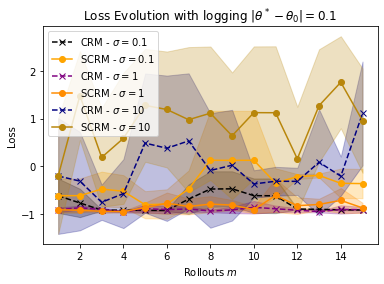

In [65]:
delta = 0.1
plt.title(r'Loss Evolution with logging $\vert \theta^* - \theta_0 \vert={}$'.format(delta))
plt.xlabel('Rollouts $m$')
plt.ylabel('Loss')

rollouts = np.arange(1, 16)

color_pairs = [('black', 'orange'), ('purple', 'darkorange'), ('navy', 'darkgoldenrod')]
l = len(crm_perfs)
    
for idx in range(l):
    color_crm, color_scrm = color_pairs[idx]
    crm_losses = crm_perfs[idx]
    crm_losses_std = crm_perfs_std[idx]
    scrm_losses = scrm_perfs[idx]
    scrm_losses_std = scrm_perfs_std[idx]
    sigma = logging_scales[idx]
    
    plt.plot(rollouts, crm_losses, 'x--', color=color_crm, label='CRM - $\sigma={}$'.format(sigma))
    plt.fill_between(rollouts,
                         crm_losses - crm_losses_std,
                         crm_losses + crm_losses_std, alpha=.25, color=color_crm, )
    plt.plot(rollouts, scrm_losses, 'o-', color=color_scrm, label='SCRM - $\sigma={}$'.format(sigma))
    plt.fill_between(rollouts,
                         scrm_losses - scrm_losses_std,
                         scrm_losses + scrm_losses_std, alpha=.25, color=color_scrm)

plt.legend(loc='best')
plt.savefig('distance_variance_compromise.pdf')

In [76]:
scrm_losses

array([-0.47830686, -0.47565932, -0.46774373, -0.51876135, -0.5726235 ,
       -0.61897201, -0.69786104, -0.76197715, -0.81837585, -0.88483053,
       -0.92322276, -0.9420493 , -0.95832741, -0.95824164, -0.96125002])

In [87]:
import pandas as pd

In [96]:
data=np.vstack([crm_losses, crm_losses_std, scrm_losses, scrm_losses_std])
df = pd.DataFrame(data.T, columns=['CRM loss', 'CRM std', 'SCRM loss', 'SCRM std'])
df.to_csv('gaussian_example.csv')  

In [99]:
df

,CRM loss,CRM std,SCRM loss,SCRM std
0,-0.478307,0.011092,-0.478307,0.011092
1,-0.490021,0.013570,-0.475659,0.036541
2,-0.518353,0.022936,-0.467744,0.043211
3,-0.553159,0.027232,-0.518761,0.049511
4,-0.585251,0.040361,-0.572623,0.067724
5,-0.621912,0.029870,-0.618972,0.064410
6,-0.648658,0.024612,-0.697861,0.056797
7,-0.662851,0.017767,-0.761977,0.040454
8,-0.685328,0.011415,-0.818376,0.031586
9,-0.707737,0.015734,-0.884831,0.023733
